### Target classifier

In [1]:
from simpletransformers.language_representation import RepresentationModel
from simpletransformers.classification import MultiLabelClassificationModel
from simpletransformers.config.model_args import ModelArgs
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')
data = data[data['source']!='SASDG_Hub'] #keep the articles classified by Willem separate as an unseen testing set
data = data.iloc[-1000:,:] # select a small subset of the data (last 1000 rows)

# import target data
target_df = pd.read_csv('Targets.csv', sep=';')

In [3]:
# function to apply model to text
def classify_sdg(text_lst):
    # see GPU avaialability
    cuda_available = torch.cuda.is_available()
    
    # import model from path (this path is the directory with all the model files)
    sdg_model = MultiLabelClassificationModel(
            "xlnet",
            r"C:\Users\gcmar\Desktop\GIT_REPOS\Transformers_simple_wandb_experiments\SASDGHUB\outputs\best_model\\",
            num_labels=17,
            use_cuda=cuda_available,
            )
    predictions, raw_outputs = sdg_model.predict(text_lst)
    return(predictions, raw_outputs)

In [24]:
# function to classify targets
def classify_sdg_target(text_lst, 
                        target_data_path='Targets.csv',
                        run_isomap=True, # run faster for multiple samples otherwise (target_data_path required when this is False) (do not use when only one sample)
                        target_embedding_reduced_path=None, # load a previously calculated and reduced embedding for the targets 'outputs/targets_embedded_reduced_gpt2_2D.csv'
                        isomap_dims = 2,
                        isomap_neigbors = 5, # has to be <= len(text_lst) a.k.a n_samples
                        pre_trained_model_type='gpt2', 
                        pre_trained_model_name='gpt2',
                        target_threshold_val=0.5):
    
    # see GPU avaialability
    cuda_available = torch.cuda.is_available()

    # define and load model from hugging face
    model_args = ModelArgs(max_seq_length=1024)
    # model import
    model = RepresentationModel(
        pre_trained_model_type,
        pre_trained_model_name, #gpt2 , gpt2-large
        args=model_args,
    )
    
    # classify sdg of text
    sdg_predictions, sdg_raw_outputs = classify_sdg(text_lst)
    # get embeddings of text
    word_embeddings = model.encode_sentences(text_lst, combine_strategy="mean")
    
    
    # ISOMAP
    if run_isomap==True: 
        # reduce isomap_neigbors to fit the number of samples
        n_samples = len(text_lst)
        if n_samples < isomap_neigbors:
            isomap_neigbors = np.max([1,n_samples-1])
            print('Reduced isomap_n_neigbors to: ', isomap_neigbors)

        # reduce dimensions of embeddings to 2 (can be reduced to higher dimensions)
        isomap = Isomap(n_components=isomap_dims, n_neighbors=isomap_neigbors-1) # input is an array with samples x features
        word_embeddings_transformed = isomap.fit_transform(word_embeddings)

        if target_embedding_reduced_path == None:
            # load pre-calculated embeddings
            target_df = pd.read_csv(target_data_path, sep=';')
            # get sentence list from target data
            target_sentence_list = target_df['text'].tolist()
            # get embeddings of targets
            target_embeddings = model.encode_sentences(target_sentence_list, combine_strategy="mean")
            target_embeddings_transformed = isomap.fit_transform(target_embeddings)

            # add labels to reduced embeddings
            target_trans_df = pd.DataFrame(target_embeddings_transformed)
            target_trans_df['target'] = target_df['target']
            target_trans_df['sdg'] = target_df['sdg']
            target_trans_df.to_csv('outputs/targets_embedded_reduced_'+pre_trained_model_name+'_'+str(isomap_dims)+'D.csv', index=False)

            # define source and target for KNN
            Y = target_trans_df
            X = pd.DataFrame(word_embeddings_transformed)
            idx_ar = np.array(range(0,17), np.int64)
            sdg_label_lst = []
            for row in (np.array(sdg_predictions)==1):
                sdg_label_lst.append(idx_ar[row])
            X['sdg'] = sdg_label_lst
            sdg_prob_lst = []
            for row in sdg_raw_outputs:
                sdg_prob_lst.append(row)
            X['sdg_probability'] = sdg_prob_lst
            
        else:
            # import reduced embedding of targets
            target_trans_df = pd.read_csv(target_embedding_reduced_path, sep=',')
            
            # define source and target for KNN
            Y = target_trans_df
            X = pd.DataFrame(word_embeddings_transformed)
            idx_ar = np.array(range(0,17), np.int64)
            sdg_label_lst = []
            for row in (np.array(sdg_predictions)==1):
                sdg_label_lst.append(idx_ar[row])
            X['sdg'] = sdg_label_lst
            sdg_prob_lst = []
            for row in sdg_raw_outputs:
                sdg_prob_lst.append(row)
            X['sdg_probability'] = sdg_prob_lst

        # plot embeddings if they are 2D
        if isomap_dims ==2:
            trans_df = pd.DataFrame(word_embeddings_transformed)
            trans_df['target'] = target_df['target']
            trans_df['sdg'] = target_df['sdg']
            trans_df.plot.scatter(0,1,c='sdg', colormap='viridis') # colour by sdg
            plt.title('Isomap 2D plot of text embedding')
            plt.show()
    
    else:
        # load pre-calculated embeddings
        target_df = pd.read_csv(target_data_path, sep=';')
        # get sentence list from target data
        target_sentence_list = target_df['text'].tolist()
        # get embeddings of targets
        target_embeddings = model.encode_sentences(target_sentence_list, combine_strategy="mean")
        
        # define source and target for KNN
        Y = pd.DataFrame(target_embeddings)
        Y['target'] = target_df['target']
        Y['sdg'] = target_df['sdg']
        X = pd.DataFrame(word_embeddings)
        idx_ar = np.array(range(0,17), np.int64)
        sdg_label_lst = []
        for row in (np.array(sdg_predictions)==1):
            sdg_label_lst.append(idx_ar[row])
        X['sdg'] = sdg_label_lst
        sdg_prob_lst = []
        for row in sdg_raw_outputs:
            sdg_prob_lst.append(row)
        X['sdg_probability'] = sdg_prob_lst
    
    
#     # create dictionary of knn models per sdg
#     # train/prepare knn models
#     knn = KNeighborsClassifier(n_neighbors=knn_n_val, weights='distance')
#     knn_models_dict = {}
#     for i in range(0+1, 17+1):
#         Y_target_df = Y[Y['sdg']==i]
#         Y_embedding_df = Y_target_df.loc[:, ~Y_target_df.columns.isin(['sdg', 'target'])]
#         model = knn.fit(Y_embedding_df, Y_target_df['target'])
#         knn_models_dict[i] = model
        
#     ############## save dict to disk and add option in function to load or train
        
#     # apply knn
#     results_df = pd.DataFrame()
#     for i,j in knn_models_dict.items():
#         results_df['text'] = text_lst
#         results_df['sdg'] = X['sdg']
#         results_df['sdg_probability'] = X['sdg_probability']
#         X_embedding_df = X.loc[:, ~X.columns.isin(['sdg', 'sdg_probability'])]
#         results_df['sdg_'+str(i)+'_targets_prob'] = j.predict_proba(X_embedding_df).tolist()
#         results_df['sdg_'+str(i)+'_targets_pred'] = j.predict(X_embedding_df).tolist()

#################### use old cosine method and use parameter search to learn distance cutoff for each SDG?
    # define final results table
    results_df = pd.DataFrame()
    results_df['text'] = text_lst
    results_df['sdg'] = X['sdg']
    results_df['sdg_probability'] = X['sdg_probability']
    # calculate pairwise cosine similarity between targets and text list
    similarity_ar = cosine_similarity(X.loc[:, ~X.columns.isin(['sdg', 'sdg_probability'])], 
                                  Y.loc[:, ~Y.columns.isin(['sdg', 'target'])],
                                 )
    results_df['target_similarity'] = similarity_ar.tolist()
    # select targets on distance sdg and threshold
    targets_ar = np.array(Y['target'])
    targets_full_ar = np.tile(targets_ar, (len(d), 1)) # expand to make full column##########################
    sdg_ar = np.array(Y['sdg'])
    sdg_full_ar = np.tile(sdg_ar, (len(d), 1)) # expand to make full column##########################
    
    
    # (dist_ar>=target_threshold_val)
    
    return results_df, targets_ar, sdg_ar, similarity_ar

In [68]:
c

array([ 1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
      dtype=int64)

In [77]:
sdg_full_ar = np.tile(c, (10,1))

In [60]:
sdg_select_ar.shape

(10,)

In [86]:
sdg_onehot_ar = np.array([])
for i in len(sdg_full_ar):
    isin_ar = np.isin(sdg_full_ar[i], sdg_select_ar[i])
    np.vstack((a,b))


In [85]:
b[isin_ar]

array(['3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9',
       '3.a', '3.b', '3.c', '3.d', '7.1', '7.2', '7.3', '7.a', '7.b',
       '9.1', '9.2', '9.3', '9.4', '9.5', '9.a', '9.b', '9.c', '16.1',
       '16.2', '16.3', '16.4', '16.5', '16.6', '16.7', '16.8', '16.9',
       '16.10', '16.a', '16.b'], dtype=object)

In [89]:
isin_ar[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

array([ 0,  3,  7,  9, 16], dtype=int64)

In [8]:
# create evaluation function for target function
# create sweep for parameter tuning with wandb with evaluation and training fucntions
# 

Some weights of the model checkpoint at gpt2 were not used when initializing GPT2ForTextRepresentation: ['h.2.ln_1.weight', 'h.2.ln_1.bias', 'h.4.mlp.c_proj.weight', 'h.0.attn.bias', 'h.0.ln_1.weight', 'h.0.mlp.c_fc.bias', 'h.4.mlp.c_fc.bias', 'h.4.mlp.c_proj.bias', 'h.11.mlp.c_fc.bias', 'h.10.attn.c_proj.bias', 'h.7.attn.c_attn.bias', 'h.8.attn.c_proj.bias', 'h.9.ln_1.weight', 'h.9.attn.c_attn.weight', 'h.5.ln_1.bias', 'h.8.attn.c_attn.bias', 'h.1.attn.c_attn.bias', 'h.0.ln_2.weight', 'h.11.attn.c_proj.weight', 'h.11.mlp.c_fc.weight', 'h.8.attn.bias', 'h.11.attn.c_attn.weight', 'h.2.mlp.c_proj.weight', 'h.2.ln_2.weight', 'h.10.attn.c_attn.bias', 'h.4.mlp.c_fc.weight', 'h.7.attn.c_attn.weight', 'h.3.mlp.c_fc.weight', 'wte.weight', 'h.3.ln_1.weight', 'h.10.ln_2.bias', 'h.0.ln_1.bias', 'h.1.ln_1.weight', 'h.7.ln_2.bias', 'h.6.attn.c_proj.weight', 'h.10.ln_1.bias', 'h.9.mlp.c_proj.bias', 'ln_f.bias', 'h.3.mlp.c_fc.bias', 'h.5.attn.c_attn.bias', 'h.6.attn.c_attn.bias', 'h.1.mlp.c_proj.weig

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

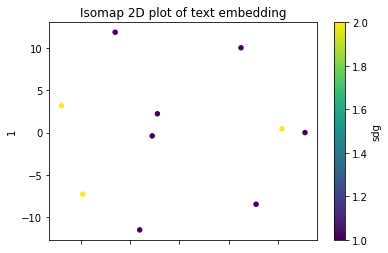

In [25]:
a,b,c,d = classify_sdg_target(data.iloc[-10:,:]['abstract'].tolist(), run_isomap=True)

In [ ]:
# modify function to be used for testing both sdg and target classification